In [12]:
import numpy as np
import numpyro as npr
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
import jax.numpy as jnp
import jax.scipy.special as jss
import arviz as az
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from numpyro.infer.reparam import TransformReparam

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
sns.set()

In [15]:
npr.set_host_device_count(mp.cpu_count())

# Example from the doc

In [16]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [17]:
def eight_schools(J, sigma, y=None):
    mu = npr.sample('mu', dist.Normal(0, 5))
    tau = npr.sample('tau', dist.HalfCauchy(5))
    with npr.plate('J', J):
        # theta = npr.sample('theta', dist.Normal(mu, tau))
        with npr.handlers.reparam(config={'theta': TransformReparam()}):
            theta = npr.sample('theta',
                               dist.TransformedDistribution(dist.Normal(0., 1.),
                                                            dist.transforms.AffineTransform(mu, tau)))
    npr.sample('obs', dist.Normal(theta, sigma), obs=y)

In [18]:
nuts_kernel = NUTS(eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:06<00:00, 216.52it/s, 7 steps of size 3.79e-01. acc. prob=0.91] 


In [19]:
mcmc.print_summary() 


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.07      3.49      3.95     -1.29     10.09    750.88      1.00
          tau      3.88      3.31      2.93      0.03      8.24    551.26      1.00
theta_base[0]      0.38      0.98      0.41     -1.30      1.83    775.55      1.00
theta_base[1]      0.13      0.94      0.16     -1.50      1.47   1245.81      1.00
theta_base[2]     -0.04      0.95     -0.03     -1.56      1.48    877.82      1.00
theta_base[3]      0.10      0.93      0.11     -1.46      1.61   1044.21      1.00
theta_base[4]     -0.10      0.94     -0.14     -1.73      1.32   1001.57      1.00
theta_base[5]     -0.10      0.93     -0.11     -1.65      1.44    902.72      1.00
theta_base[6]      0.38      0.97      0.38     -1.16      1.93    791.36      1.00
theta_base[7]      0.12      1.01      0.16     -1.68      1.58   1075.65      1.00

Number of divergences: 0


---

# Hierarchical model of forgetting

In [20]:
def model(n_u, n_w, u, w, d, r, y):

    sg_w1 = npr.sample('sg_w1',  dist.InverseGamma(1, 1))
    sg_u1 = npr.sample('sg_u1', dist.InverseGamma(1, 1))
    sg_theta1 = npr.sample('sg_theta1', dist.InverseGamma(1, 1))
    mu1 = npr.sample('mu1', dist.Normal(0, 10))

    sg_w2 = npr.sample('sg_w2',  dist.InverseGamma(1, 1))
    sg_u2 = npr.sample('sg_u2', dist.InverseGamma(1, 1))
    sg_theta2 = npr.sample('sg_theta2', dist.InverseGamma(1, 1))
    mu2 = npr.sample('mu2', dist.Normal(0, 10))
    
    with npr.plate('users', n_u):
        with npr.handlers.reparam(config={'U1': TransformReparam(), 'U2': TransformReparam()}):
            U1 = npr.sample('U1', dist.TransformedDistribution(
                dist.Normal(0., 1.),
                dist.transforms.AffineTransform(0., sg_u1)))
            U2 = npr.sample('U2', dist.TransformedDistribution(
                dist.Normal(0., 1.),
                dist.transforms.AffineTransform(0., sg_u2)))
    
    with npr.plate('words', n_w):
        with npr.handlers.reparam(config={'W1': TransformReparam(), 'W2': TransformReparam()}):
            W1 = npr.sample('W1', dist.TransformedDistribution(
                dist.Normal(0., 1.),
                dist.transforms.AffineTransform(0., sg_w1)))
            W2 = npr.sample('W2', dist.TransformedDistribution(
                dist.Normal(0., 1.),
                dist.transforms.AffineTransform(0., sg_w2)))
    
    mu_theta1 = mu1 + U1[u] + W1[w]
    mu_theta2 = mu2 + U2[u] + W2[w]

    with npr.handlers.reparam(config={'a': TransformReparam(), 'b': TransformReparam()}):
        a = npr.sample('a', 
                       dist.TransformedDistribution(
                            dist.TransformedDistribution(
                                dist.Normal(0., 1.),
                                dist.transforms.AffineTransform(mu_theta1, sg_theta1)),
                            dist.transforms.ExpTransform()))
        b = npr.sample('b',
                       dist.TransformedDistribution(
                            dist.TransformedDistribution(
                                dist.Normal(0., 1.),
                                dist.transforms.AffineTransform(mu_theta2, sg_theta2)),
                            dist.transforms.SigmoidTransform()))
    
    logits = - a * (1-b)**r * d
    npr.sample('obs', dist.Bernoulli(logits=logits), obs=y)

# Produce artificial data

## How does it look like?

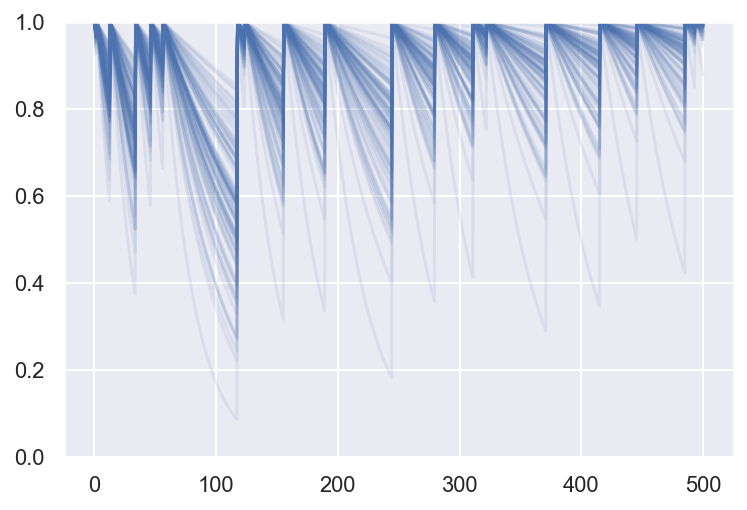

In [21]:
theta1 = np.random.normal(-4, 0.5, size=100)
theta2 = np.random.normal(-2, 0.4, size=100)

max_t = 5* 10**2
n_pres = 20

x = np.linspace(0, max_t, 1000)
pres = np.concatenate(([0,], np.sort(np.random.uniform(0, max_t, n_pres-1))))

n = np.zeros(x.shape)

delta = np.zeros(x.shape)
for i, p in enumerate(pres):
    delta[x>p] = x[x>p] - p
    n[x>p] = i
fig, ax = plt.subplots()

for th1, th2 in zip(theta1, theta2):
    alpha, beta = np.exp(th1), expit(th2)
    # print("alpha-beta", alpha, beta)
    p = np.exp(-alpha*(1-beta)**n*delta)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1);

## Create a batch

In [22]:
# Seed
np.random.seed(123)

sg_u = 0.1, 0.1
sg_w = 0.5, 0.3

sg_theta = (0.001, 0.001)

mu = (-4, 0.3)
n_param = 2

# Number of users
n_u = 20
# Number of words
n_w = 10
# Number of obs max
n_o_max = 10

delta_max = 100

# Number of words seen by a single user
n_w_by_u = np.random.randint(3, 5, n_u)
n_o_by_u = np.random.randint(n_o_max-2, n_o_max, n_u)
n_obs = n_o_by_u.sum()

U = np.random.normal(0, sg_u, size=(n_u, n_param))   # User ability
W = np.random.normal(0, sg_w, size=(n_w, n_param))   # Item difficulty
rd = np.random.normal(size=(n_u, n_o_max))
delta = np.random.uniform(0, delta_max, size=(n_u, n_o_max))

y = np.zeros(shape=n_obs, dtype=int)
d = np.zeros(shape=n_obs, dtype=float)
w = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)

idx = 0
for i_u in range(n_u):
    
    n_wu = n_w_by_u[i_u]
    n_ou = n_o_by_u[i_u]
    
    seen = np.random.choice(np.arange(n_w), replace=False, size=n_wu)
    w_u = np.random.choice(seen, replace=True, size=n_ou)
    counts = {word: 0 for word in seen}
    r_u = np.zeros(shape=n_ou, dtype=int)
    for i, word in enumerate(w_u):
        r_u[i] = counts[word]
        counts[word] += 1
    
    d_u = delta[i_u, :n_ou]

    mu_u = mu + U[i_u] + W[w_u]
    
    theta = np.random.normal(mu_u, sg_theta)
    
    a = np.exp(theta[:, 0])
    b = expit(theta[:, 1])
    
    exponent = - a *(1-b)**r_u * d_u
    p = np.exp(exponent)
    
    y_u = p > rd[i_u, :n_ou]
    
    y[idx:idx+n_ou] = y_u
    d[idx:idx+n_ou] = d_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou

In [23]:
data_artificial = {'n_u': n_u, 'n_w': n_w, 
                   'u': u, 'w': w, 
                   'd': d, 'r': r,
                   'y': y}

In [24]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.7561073138435603 0.9890494504824527 0.4695620424719236
0.7810650887573964 0 1


# Run with artificial data

In [25]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, **data_artificial, extra_fields=('potential_energy',))

In [26]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 U1_base[0]     -0.01      0.99     -0.02     -1.62      1.63   8910.84      1.00
 U1_base[1]     -0.02      1.01     -0.00     -1.58      1.70  11319.97      1.00
 U1_base[2]      0.01      0.98      0.01     -1.63      1.59  10114.33      1.00
 U1_base[3]      0.00      1.01     -0.01     -1.58      1.70  10741.02      1.00
 U1_base[4]      0.02      1.01      0.02     -1.63      1.68  10367.78      1.00
 U1_base[5]      0.00      1.01      0.01     -1.60      1.73  11413.99      1.00
 U1_base[6]      0.00      1.01      0.01     -1.58      1.72  10642.78      1.00
 U1_base[7]     -0.01      1.01     -0.02     -1.66      1.65  11608.36      1.00
 U1_base[8]     -0.00      0.97     -0.00     -1.67      1.56  10139.30      1.00
 U1_base[9]     -0.02      1.00     -0.02     -1.59      1.67  10792.02      1.00
U1_base[10]     -0.02      1.01     -0.02     -1.71      1.59  11487.92      1.00
U1_base[11]    

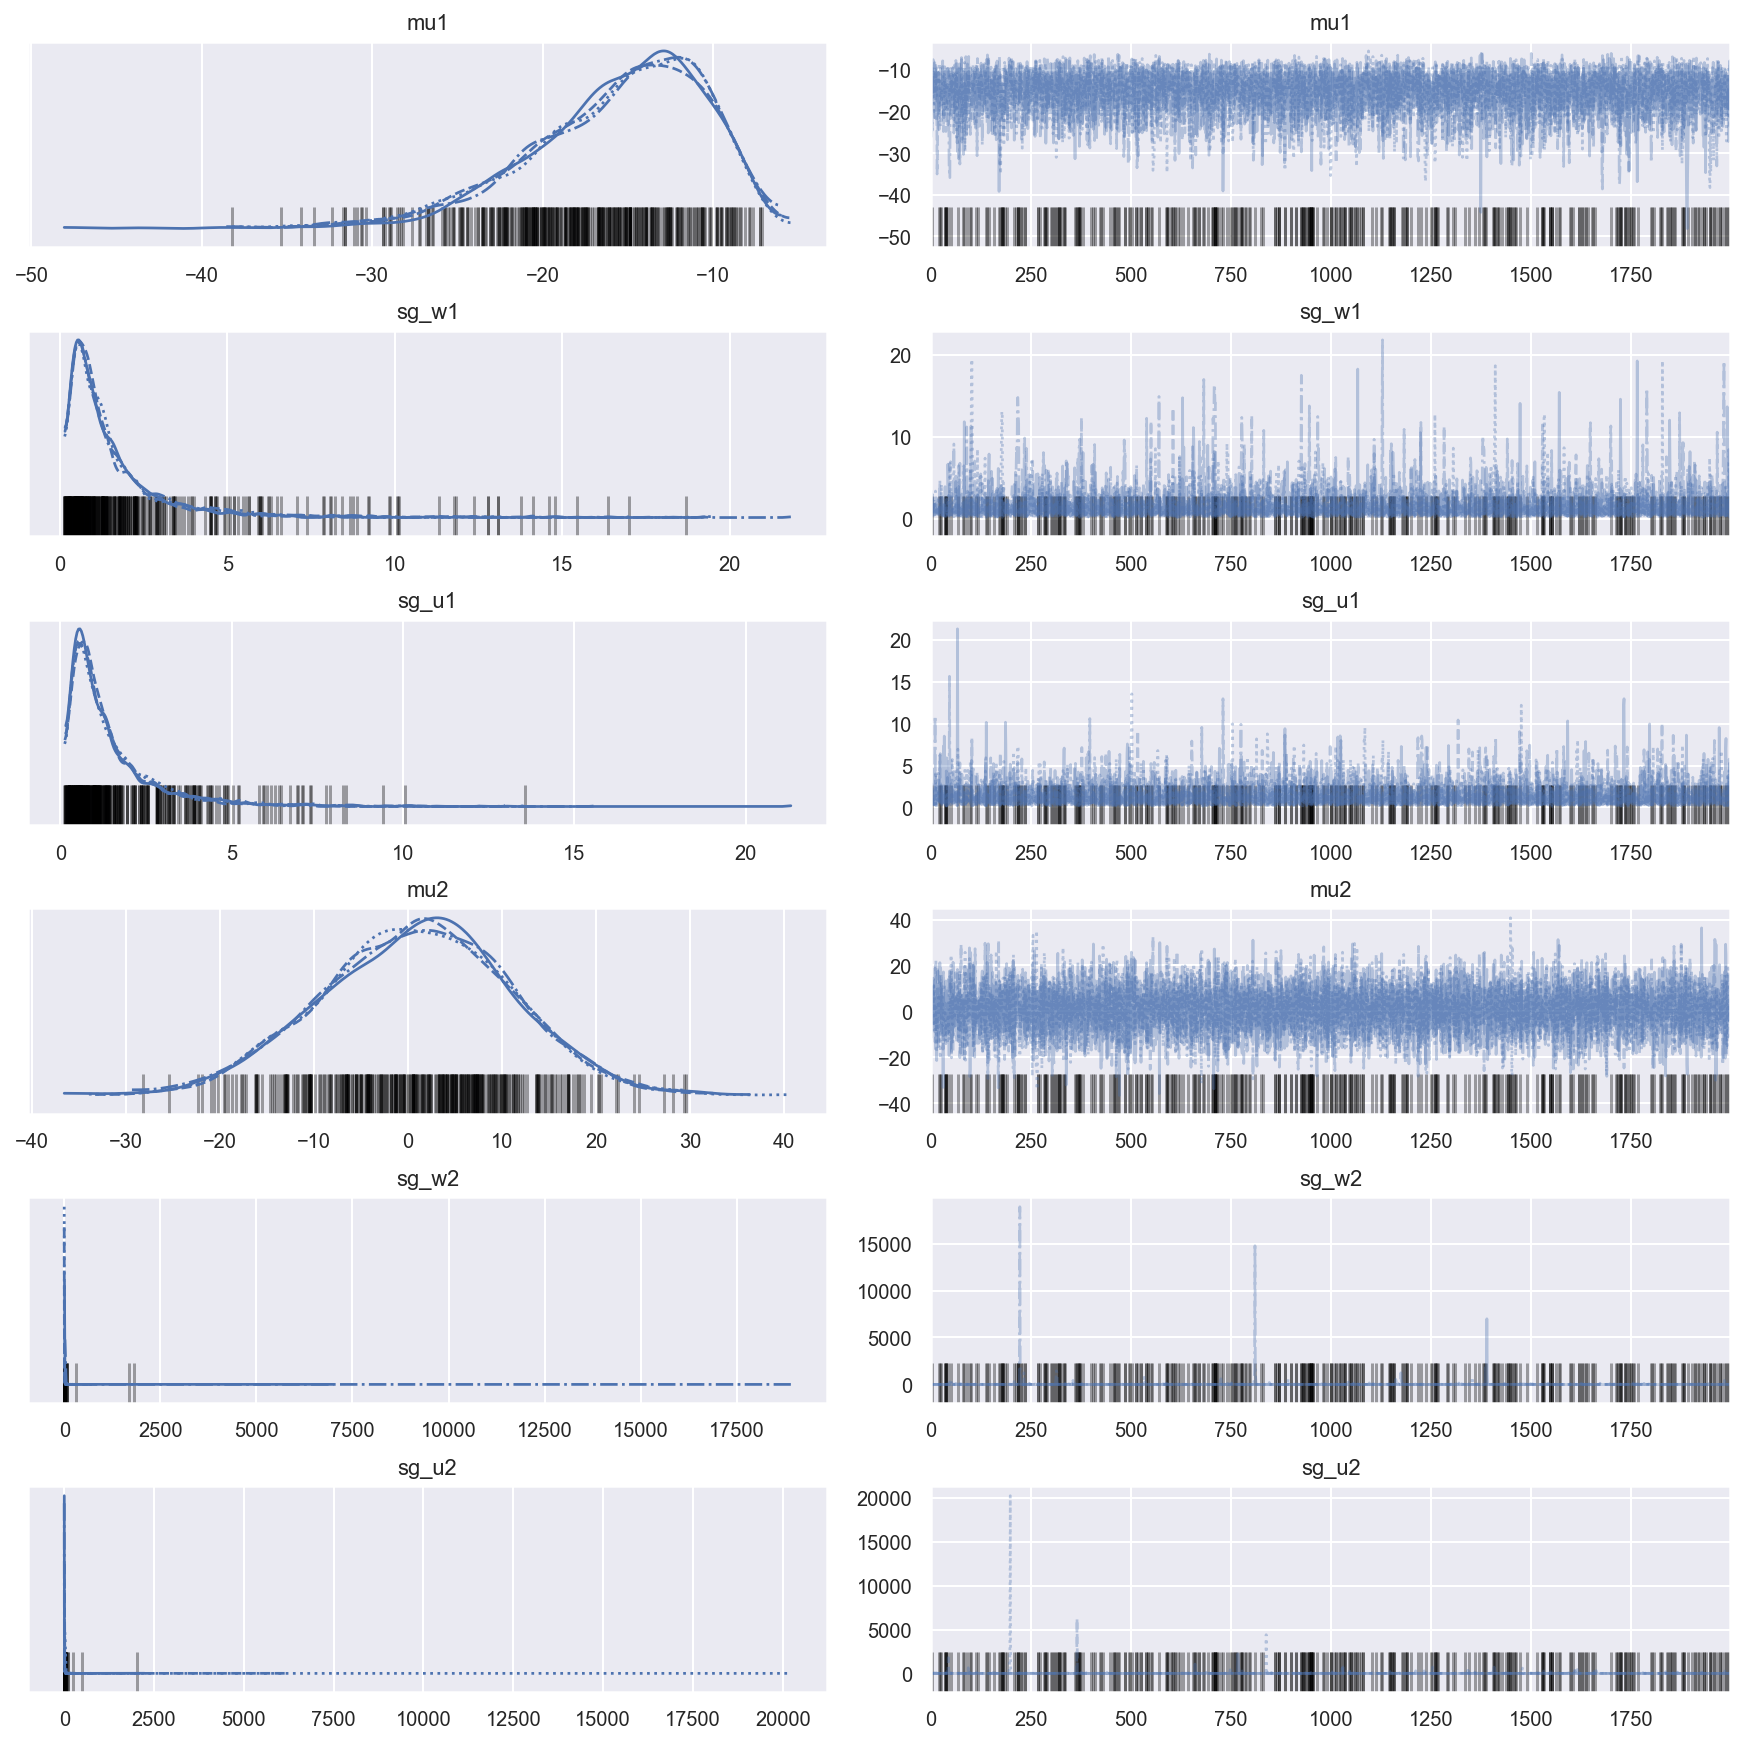

In [27]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);

# Run with real data

In [28]:
df = pd.read_csv("data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done
49739,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14
49740,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14
49741,goldfish@active.fi,active.fi,ThresholdCondition,1000,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14
49742,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14
49743,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,179,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14
147618,azalea@active.fi,active.fi,ThresholdCondition,1071,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14
147619,azalea@active.fi,active.fi,ThresholdCondition,1196,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14
147620,azalea@active.fi,active.fi,ThresholdCondition,1282,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14


In [29]:
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 

In [30]:
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values

In [31]:
n_u = len(df.user.unique())
n_w = len(df.item.unique())
print(f"n_u={n_u}, n_w={n_w}" )

n_u=53, n_w=1998


In [32]:
# Copy actual item ID
df["item_id"] = df.item

In [33]:
for i, i_id in enumerate(df.item_id.unique()): 
    df.loc[df.item_id == i_id, 'item'] = i

In [34]:
print(df.item.min())
print(df.item.max())

0
1997


In [35]:
n_o_by_u = np.zeros(shape=n_u, dtype=int)
for u, (user, user_df) in enumerate(df.groupby("user")):
    n_o_by_u[u] = len(user_df) - len(user_df.item.unique()) # Do not count first presentation
n_o_max = n_o_by_u.max()
n_obs = n_o_by_u.sum()
print( f"n_o_max={n_o_max}")
print(f"n_o_min={n_o_by_u.min()}")
print(f"n_obs={n_obs}")

n_o_max=1404
n_o_min=1285
n_obs=70618


In [36]:
y = np.zeros(shape=n_obs, dtype=int)
d = np.zeros(shape=n_obs, dtype=float)
w = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)

idx = 0

for i_u, (user, user_df) in enumerate(df.groupby("user")):
    
    user_df = user_df.sort_values(by="timestamp")
    seen = user_df.item.unique()
    w_u = user_df.item.values      # Words
    ts_u = user_df.timestamp.values
    counts = {word: -1 for word in seen}
    last_pres = {word: None for word in seen}
    r_u = np.zeros(len(user_df))   # Number of repetitions
    d_u = np.zeros(r_u.shape)      # Time elapsed since last repetition 
    for i, word in enumerate(w_u):
        ts = ts_u[i]
        r_u[i] = counts[word]
        if last_pres[word] is not None:
            d_u[i] =  ts - last_pres[word]
        counts[word] += 1
        last_pres[word] = ts
    
    to_keep = r_u >= 0
    y_u = user_df.success.values[to_keep]
    r_u = r_u[to_keep]
    w_u = w_u[to_keep]
    d_u = d_u[to_keep]
    
    n_ou = len(y_u)
    
    assert n_o_by_u[i_u] == n_ou
    
    y[idx:idx+n_ou] = y_u
    d[idx:idx+n_ou] = d_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou

data = {'n_u': n_u, 'n_w': n_w, 
        'u': u, 'w': w, 
        'd': d, 'r': r,
        'y': y}

In [37]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=4)
rng_key = random.PRNGKey(123)
mcmc.run(rng_key, **data, extra_fields=('potential_energy',))

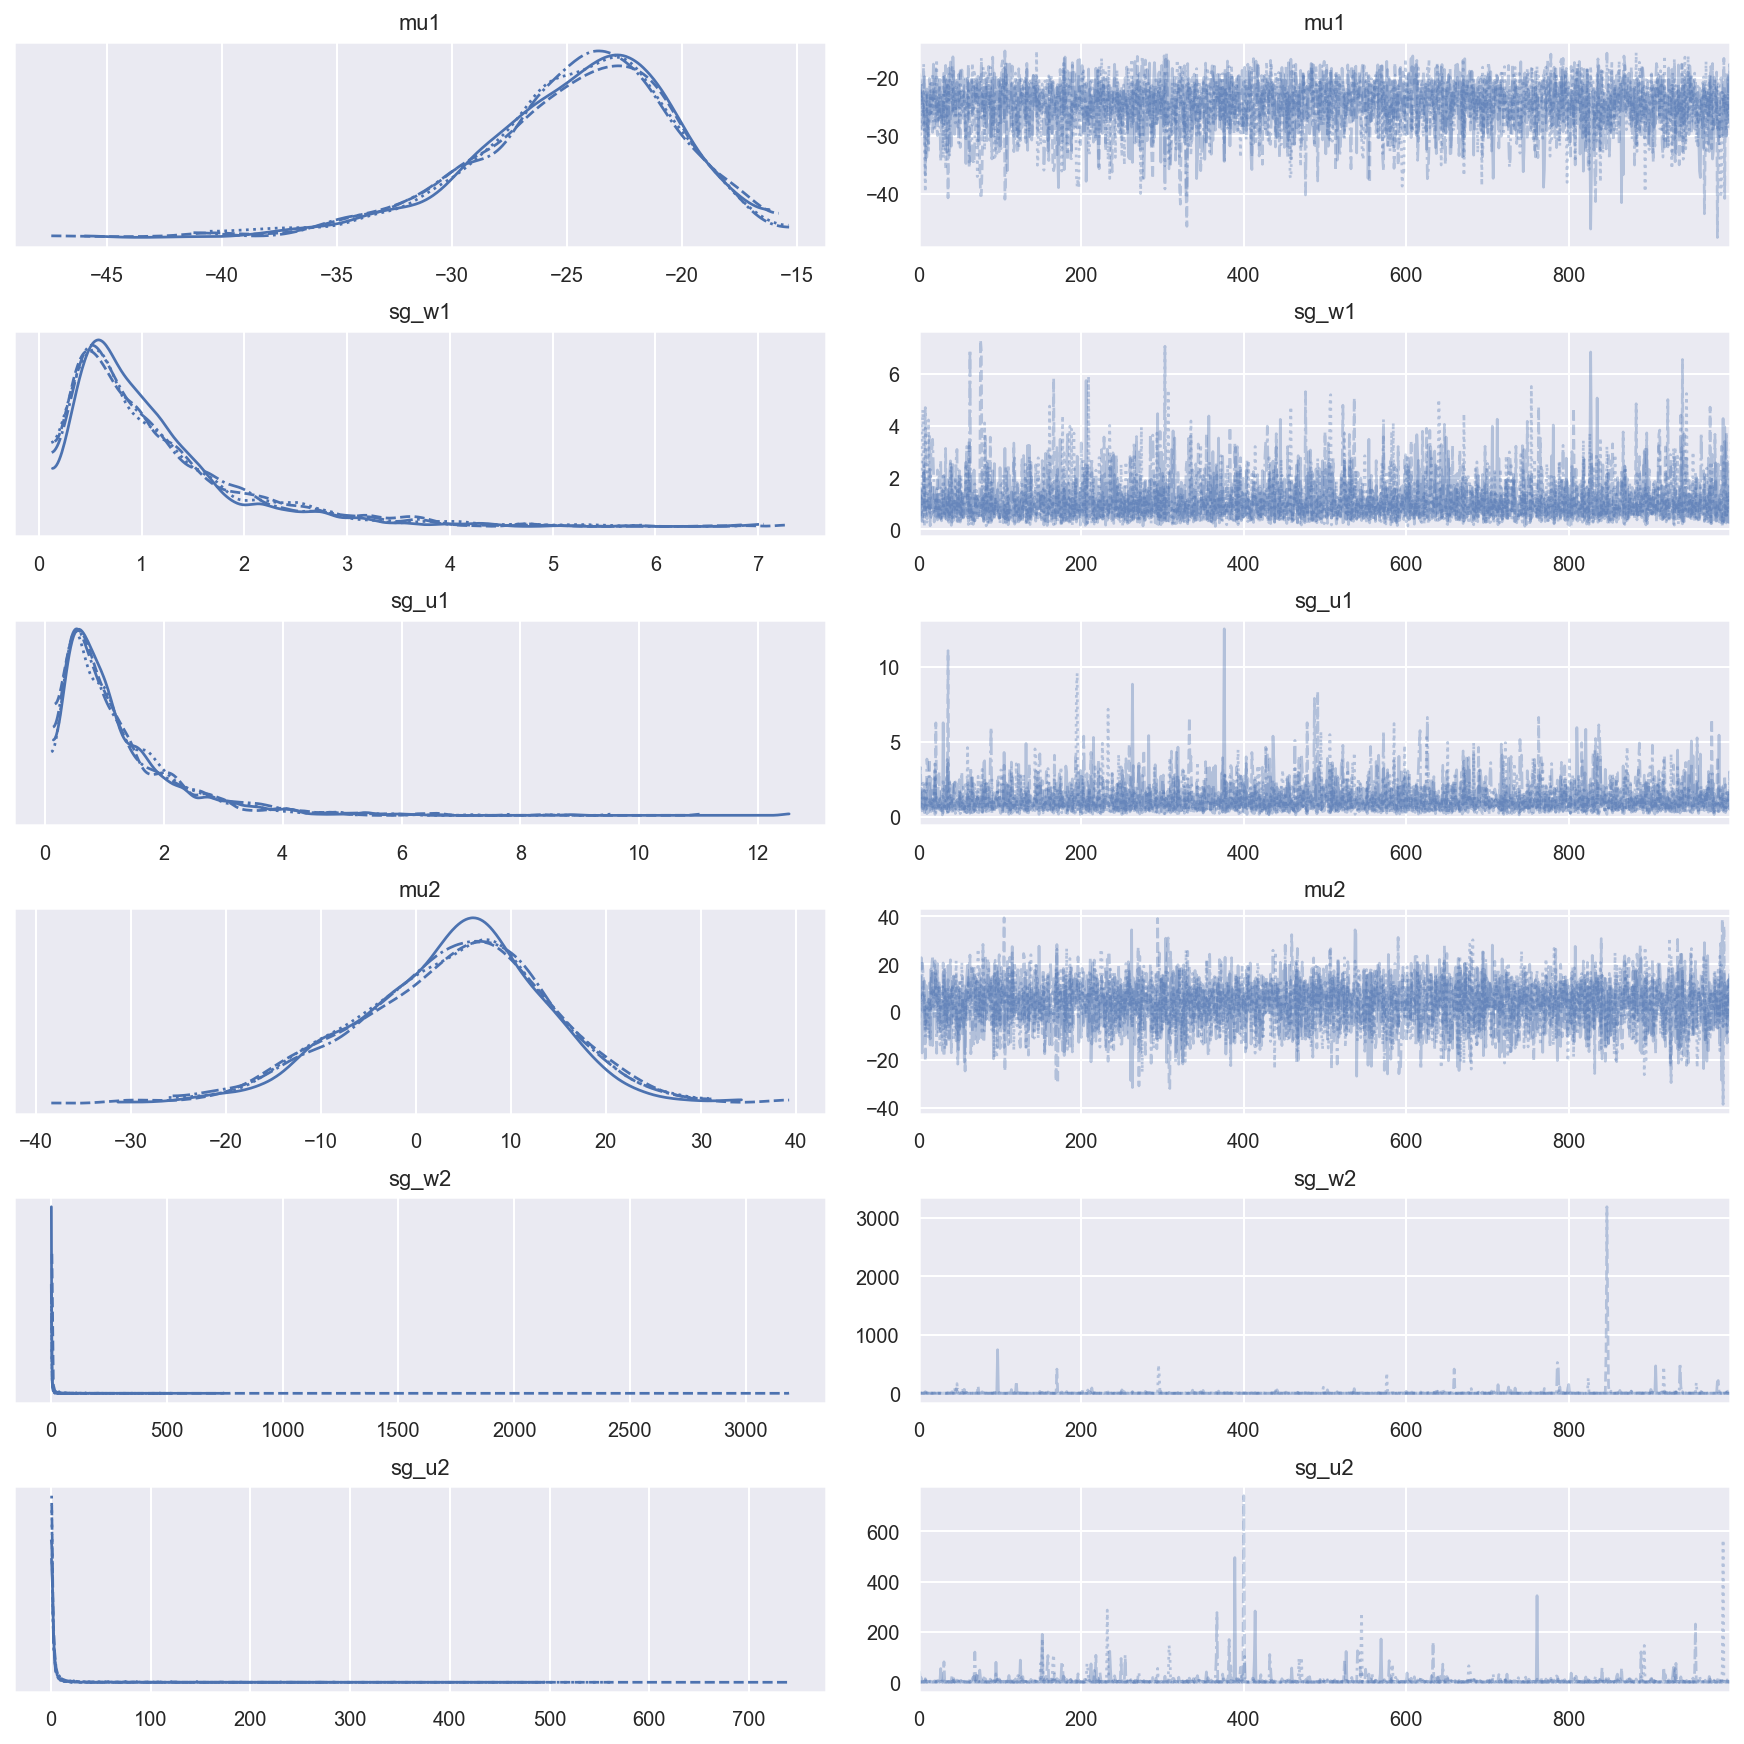

In [38]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);